In [28]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [29]:
root_path  = '../data/final_data/'
data_train = pd.read_csv(root_path+'sensor_train_final.csv')
data_test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = data_train.groupby('fragment_id')['behavior_id'].min()
data_test['fragment_id'] += 100000
label = 'behavior_id'
data = pd.concat([data_train, data_test], sort=False,ignore_index=True)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]
df["count"] = data.groupby("fragment_id")["time_point"].count()

featureList = ["count"]

In [30]:
# LGB model
import joblib
lgboof = joblib.load("LGB_OOF.pkl")
oof = lgboof["oof"]
preds = lgboof["test"]

stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["lgb_"+str(i)] = stack_array[:,i]
featureList += ["lgb_"+str(i)for i in range(20)]

(31000, 20)


In [31]:
# LSTM model
import joblib 
lstmoof = joblib.load("LSTM8370.83753_dict.pkl")
oof = lstmoof["oof"]
preds = lstmoof["test"]

stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["lstm_"+str(i)] = stack_array[:,i]
featureList += ["lstm_"+str(i)for i in range(20)]

(31000, 20)


In [32]:
# CNN
import joblib 

cnnoof = joblib.load("all_stragety_lcy1_0.84695_dict.pkl")
oof = cnnoof["oof"]
preds = cnnoof["test"]

stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["CNN_"+str(i)] = stack_array[:,i]
featureList += ["CNN_"+str(i)for i in range(20)]


(31000, 20)


In [33]:
df = df.fillna(0)
df.loc[:15000,"istrain"] = 1
df.loc[15000:,"istrain"] = 0

train_df = df[df["istrain"]==1].reset_index(drop=True)
test_df = df[df["istrain"]==0].reset_index(drop=True)

drop_feat = ["istrain"]
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]
print()

61
['count', 'lgb_0', 'lgb_1', 'lgb_2', 'lgb_3', 'lgb_4', 'lgb_5', 'lgb_6', 'lgb_7', 'lgb_8', 'lgb_9', 'lgb_10', 'lgb_11', 'lgb_12', 'lgb_13', 'lgb_14', 'lgb_15', 'lgb_16', 'lgb_17', 'lgb_18', 'lgb_19', 'lstm_0', 'lstm_1', 'lstm_2', 'lstm_3', 'lstm_4', 'lstm_5', 'lstm_6', 'lstm_7', 'lstm_8', 'lstm_9', 'lstm_10', 'lstm_11', 'lstm_12', 'lstm_13', 'lstm_14', 'lstm_15', 'lstm_16', 'lstm_17', 'lstm_18', 'lstm_19', 'CNN_0', 'CNN_1', 'CNN_2', 'CNN_3', 'CNN_4', 'CNN_5', 'CNN_6', 'CNN_7', 'CNN_8', 'CNN_9', 'CNN_10', 'CNN_11', 'CNN_12', 'CNN_13', 'CNN_14', 'CNN_15', 'CNN_16', 'CNN_17', 'CNN_18', 'CNN_19']



In [34]:
scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.1,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 20,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 4,
    'seed': 2020,
    'max_depth': 10,
    'num_leaves': 64,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}

oof_train = np.zeros((len(train_x), 20))
preds = np.zeros((len(test_x), 20))
folds = 5
seeds = [44, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0606667	valid_1's multi_error: 0.114333
[40]	training's multi_error: 0.0246667	valid_1's multi_error: 0.117333
[60]	training's multi_error: 0.006	valid_1's multi_error: 0.116
Early stopping, best iteration is:
[21]	training's multi_error: 0.0585833	valid_1's multi_error: 0.113667


2063

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0603333	valid_1's multi_error: 0.127667
[40]	training's multi_error: 0.0236667	valid_1's multi_error: 0.126
[60]	training's multi_error: 0.00616667	valid_1's multi_error: 0.127667
Early stopping, best iteration is:
[27]	training's multi_error: 0.0455833	valid_1's multi_error: 0.124333


373

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0605833	valid_1's multi_error: 0.127667
[40]	training's multi_error: 0.0253333	valid_1's multi_error: 0.129333
[60]	training's multi_error: 0.00666667	valid_1's multi_error: 0.129667
Early stopping, best iteration is:
[25]	training's multi_error: 0.05125	valid_1's multi_error: 0.125667


6262

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0589167	valid_1's multi_error: 0.138
[40]	training's multi_error: 0.0231667	valid_1's multi_error: 0.138
[60]	training's multi_error: 0.00625	valid_1's multi_error: 0.135667
[80]	training's multi_error: 0.00133333	valid_1's multi_error: 0.137667
[100]	training's multi_error: 0.000666667	valid_1's multi_error: 0.138
Early stopping, best iteration is:
[60]	training's multi_error: 0.00625	valid_1's multi_error: 0.135667


80

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.058	valid_1's multi_error: 0.129667
[40]	training's multi_error: 0.02325	valid_1's multi_error: 0.130333
[60]	training's multi_error: 0.00608333	valid_1's multi_error: 0.130333
[80]	training's multi_error: 0.00116667	valid_1's multi_error: 0.128
[100]	training's multi_error: 0.000416667	valid_1's multi_error: 0.129
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.13
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.128333
Early stopping, best iteration is:
[96]	training's multi_error: 0.000416667	valid_1's multi_error: 0.126


228

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05975	valid_1's multi_error: 0.130667
[40]	training's multi_error: 0.0233333	valid_1's multi_error: 0.131
[60]	training's multi_error: 0.00608333	valid_1's multi_error: 0.130333
[80]	training's multi_error: 0.00183333	valid_1's multi_error: 0.130667
[100]	training's multi_error: 0.00075	valid_1's multi_error: 0.130667
[120]	training's multi_error: 0.00025	valid_1's multi_error: 0.129
Early stopping, best iteration is:
[88]	training's multi_error: 0.00108333	valid_1's multi_error: 0.128667


196

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0594167	valid_1's multi_error: 0.130333
[40]	training's multi_error: 0.0243333	valid_1's multi_error: 0.126333
[60]	training's multi_error: 0.00683333	valid_1's multi_error: 0.126333
[80]	training's multi_error: 0.00191667	valid_1's multi_error: 0.125333
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.126667
[120]	training's multi_error: 0.0005	valid_1's multi_error: 0.127333
Early stopping, best iteration is:
[80]	training's multi_error: 0.00191667	valid_1's multi_error: 0.125333


164

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0595	valid_1's multi_error: 0.119
[40]	training's multi_error: 0.0244167	valid_1's multi_error: 0.119333
[60]	training's multi_error: 0.00591667	valid_1's multi_error: 0.119
Early stopping, best iteration is:
[16]	training's multi_error: 0.0664167	valid_1's multi_error: 0.116333


320

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0608333	valid_1's multi_error: 0.125333
[40]	training's multi_error: 0.025	valid_1's multi_error: 0.126333
[60]	training's multi_error: 0.00516667	valid_1's multi_error: 0.123667
[80]	training's multi_error: 0.00116667	valid_1's multi_error: 0.122667
[100]	training's multi_error: 0.000166667	valid_1's multi_error: 0.123333
[120]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.121667
[140]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.123
[160]	training's multi_error: 0	valid_1's multi_error: 0.122667
Early stopping, best iteration is:
[128]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.121


356

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0584167	valid_1's multi_error: 0.133
[40]	training's multi_error: 0.0264167	valid_1's multi_error: 0.134
[60]	training's multi_error: 0.00583333	valid_1's multi_error: 0.135
Early stopping, best iteration is:
[17]	training's multi_error: 0.064	valid_1's multi_error: 0.132667


324

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.06	valid_1's multi_error: 0.128
[40]	training's multi_error: 0.0239167	valid_1's multi_error: 0.132333
[60]	training's multi_error: 0.00583333	valid_1's multi_error: 0.131
Early stopping, best iteration is:
[11]	training's multi_error: 0.0760833	valid_1's multi_error: 0.125667


300

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0605	valid_1's multi_error: 0.122667
[40]	training's multi_error: 0.02575	valid_1's multi_error: 0.124
[60]	training's multi_error: 0.00666667	valid_1's multi_error: 0.123667
Early stopping, best iteration is:
[14]	training's multi_error: 0.0731667	valid_1's multi_error: 0.121


312

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0595	valid_1's multi_error: 0.131333
[40]	training's multi_error: 0.0238333	valid_1's multi_error: 0.133333
[60]	training's multi_error: 0.00616667	valid_1's multi_error: 0.135333
Early stopping, best iteration is:
[15]	training's multi_error: 0.0696667	valid_1's multi_error: 0.128333


316

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05925	valid_1's multi_error: 0.122333
[40]	training's multi_error: 0.025	valid_1's multi_error: 0.122667
[60]	training's multi_error: 0.00575	valid_1's multi_error: 0.122
[80]	training's multi_error: 0.00191667	valid_1's multi_error: 0.123
[100]	training's multi_error: 0.00075	valid_1's multi_error: 0.121667
Early stopping, best iteration is:
[62]	training's multi_error: 0.0055	valid_1's multi_error: 0.120333


92

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0595833	valid_1's multi_error: 0.134333
[40]	training's multi_error: 0.0264167	valid_1's multi_error: 0.129667
[60]	training's multi_error: 0.00691667	valid_1's multi_error: 0.127667
[80]	training's multi_error: 0.00175	valid_1's multi_error: 0.128333
[100]	training's multi_error: 0.00075	valid_1's multi_error: 0.129333
Early stopping, best iteration is:
[54]	training's multi_error: 0.01075	valid_1's multi_error: 0.126667


60

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0600833	valid_1's multi_error: 0.126
[40]	training's multi_error: 0.0251667	valid_1's multi_error: 0.126333
[60]	training's multi_error: 0.00575	valid_1's multi_error: 0.128667
Early stopping, best iteration is:
[19]	training's multi_error: 0.0615	valid_1's multi_error: 0.125


332

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0601667	valid_1's multi_error: 0.128667
[40]	training's multi_error: 0.0248333	valid_1's multi_error: 0.125667
[60]	training's multi_error: 0.00641667	valid_1's multi_error: 0.129333
[80]	training's multi_error: 0.00133333	valid_1's multi_error: 0.126333
Early stopping, best iteration is:
[46]	training's multi_error: 0.017	valid_1's multi_error: 0.124


30

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0615833	valid_1's multi_error: 0.125333
[40]	training's multi_error: 0.0249167	valid_1's multi_error: 0.123333
[60]	training's multi_error: 0.00616667	valid_1's multi_error: 0.122667
[80]	training's multi_error: 0.001	valid_1's multi_error: 0.123333
[100]	training's multi_error: 0.000333333	valid_1's multi_error: 0.121333
Early stopping, best iteration is:
[68]	training's multi_error: 0.00308333	valid_1's multi_error: 0.120667


116

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.06125	valid_1's multi_error: 0.127
[40]	training's multi_error: 0.0238333	valid_1's multi_error: 0.121667
[60]	training's multi_error: 0.00591667	valid_1's multi_error: 0.123667
[80]	training's multi_error: 0.00133333	valid_1's multi_error: 0.125
Early stopping, best iteration is:
[40]	training's multi_error: 0.0238333	valid_1's multi_error: 0.121667


12

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.059	valid_1's multi_error: 0.13
[40]	training's multi_error: 0.0235	valid_1's multi_error: 0.131
[60]	training's multi_error: 0.0055	valid_1's multi_error: 0.128333
Early stopping, best iteration is:
[23]	training's multi_error: 0.0529167	valid_1's multi_error: 0.128


357

In [35]:
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

,feat,gain,split
48,CNN_7,11983.911708,1819
17,lgb_16,9953.930847,1484
20,lgb_19,9375.355082,821
46,CNN_5,8855.297567,1962
9,lgb_8,8771.549033,1482
50,CNN_9,8037.791333,1628
13,lgb_12,7943.515531,1984
52,CNN_11,7871.047307,1869
40,lstm_19,7470.183928,1136
18,lgb_17,7450.885394,1681


,feat,gain,split
26,lstm_5,1973.957457,2225
39,lstm_18,6565.454937,2165
53,CNN_12,5943.361991,2126
32,lstm_11,1604.831848,2106
35,lstm_14,873.567421,2097
33,lstm_12,2934.792443,2058
38,lstm_17,2095.121784,2024
23,lstm_2,824.934767,1997
30,lstm_9,908.447881,1996
13,lgb_12,7943.515531,1984


In [36]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
        '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
        '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [37]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.8762
0.89228


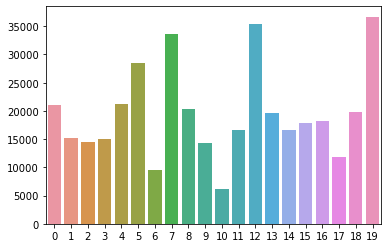

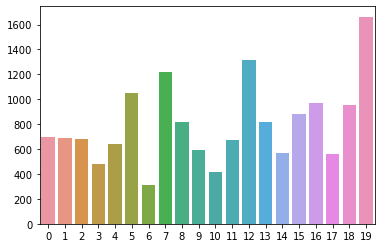

In [38]:
sub = pd.read_csv(root_path+'submit_example.csv')

sub['behavior_id'] = labels

vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('emsemble%.5f.csv' % score, index=False)